### Importing all libraries and packages

In [1]:
#--- setup and import
import os, sys
import numpy as np
import pandas as pd
from importlib import reload
from datetime import time
import matplotlib.pyplot as plt
from importlib import reload

sys.path.insert(0, os.path.abspath(".."))

root = os.path.abspath("..")  # because your notebook is in /notebooks
if root not in sys.path:
    sys.path.append(root)

import src.feature_time as FT
import src.feature_volatility as FVOL
import src.feature_levels as FLEV

reload(FT)
reload(FVOL)
reload(FLEV)






<module 'src.feature_levels' from 'c:\\Users\\user\\Forex_prediction\\src\\feature_levels.py'>

### Read file and import tz-aware time features related to FX market

In [2]:
# --- Config ---
CSV_PATH = "../data/clean/EUR_USD_COMBINED_2021-2025_4years.csv"   
TS_COL   = "Gmt time"                              #
USE_CYCLICAL = False                               # Importing date related data in cyclical format for better NN performance 
SAVE_FEATHER = "../data/clean/minutes_features_pdf.feather"


In [3]:
# Loading the file
# Currently data consists of 4 years of minute data for EUR/USD
# and has GMT time OHLC and Volume columns
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
df.head(3)


Loaded: (1486245, 6)


,Gmt time,Open,High,Low,Close,Volume
0,2021-08-16 00:00:00,1.17939,1.17957,1.17937,1.17957,52.95
1,2021-08-16 00:01:00,1.17958,1.17963,1.17953,1.17953,14.39
2,2021-08-16 00:02:00,1.17954,1.17954,1.17944,1.17944,17.46


In [4]:
df = pd.read_csv(CSV_PATH, parse_dates=["Gmt time"])

# force Volume to be numeric (coerce errors into NaN)
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# now drop NA/zero Volume
before = len(df)
df = df.dropna(subset=["Volume"])
df = df[df["Volume"] > 0]
after = len(df)
### current version of data has no NA/zero Volume rows , removed while concatinating files
print(f"Dropped {before - after} rows ({100*(before-after)/before:.2f}%) due to NA/zero Volume")

# sanity check
print("Unique Volume values (sample):", df["Volume"].unique()[:20])


Dropped 0 rows (0.00%) due to NA/zero Volume
Unique Volume values (sample): [52.95 14.39 17.46 16.03 12.33 28.38 32.48 28.08  9.   14.38 13.38 22.08
 26.02 16.37 16.7  81.06 49.89 19.25 17.33 22.85]


In [5]:
df = FT.add_ny_session_markers(
    df,
    dt_col="Gmt time",
    market_open_local="09:30",### explicitly defining market open and close time for NY
    market_close_local="16:00",
    warmup_minutes=30,
    roll_weekends=True,   # <- important
)


In [6]:
def _to_utc(series: pd.Series) -> pd.Series:
    s = pd.to_datetime(series, utc=False, errors="coerce")
    # if tz-naive, assume it's already UTC; if tz-aware (e.g., America/New_York), convert to UTC
    if getattr(s.dt, "tz", None) is None:
        return s.dt.tz_localize("UTC")
    return s.dt.tz_convert("UTC")


### Normalizing session markers

Ensures session markers are present in UTC:
Creates `dt_utc` if missing.  
Converts NY-local open/close/warmup → UTC.
Guarantees columns: `ny_open_utc`, `ny_warmup_end_utc`, `ny_close_utc`, `date_us_open`.

In [7]:
def normalize_session_markers(df_in: pd.DataFrame, dt_col: str = TS_COL, warmup_minutes: int = 30) -> pd.DataFrame:
    d = df_in.copy()
    # Ensure dt_utc
    if "dt_utc" not in d.columns:
        d["dt_utc"] = pd.to_datetime(d[dt_col], utc=True)
    # Build UTC markers from NY-local if missing
    if "ny_open_utc" not in d.columns:
        if "ny_open_ny" in d.columns:
            d["ny_open_utc"] = _to_utc(d["ny_open_ny"])
    if "ny_close_utc" not in d.columns:
        if "ny_close_ny" in d.columns:
            d["ny_close_utc"] = _to_utc(d["ny_close_ny"])
    if "ny_warmup_end_utc" not in d.columns:
        if "ny_warmup_end_ny" in d.columns:
            d["ny_warmup_end_utc"] = _to_utc(d["ny_warmup_end_ny"])
        elif "ny_open_utc" in d.columns:
            d["ny_warmup_end_utc"] = d["ny_open_utc"] + pd.Timedelta(minutes=warmup_minutes)
    # Final sanity: we must have these
    needed = ["ny_open_utc","ny_warmup_end_utc","ny_close_utc","date_us_open"]
    missing = [c for c in needed if c not in d.columns]
    if missing:
        raise KeyError(f"Missing session markers after normalization: {missing}")
    return d

df = normalize_session_markers(df, dt_col=TS_COL, warmup_minutes=30)

### Volatility flag via ATR
Classifies each US day as volatile or not using ATR

In [8]:
# stricter or looser binary flag:
df = FVOL.attach_volatility_score(
    df,
    dt_col="Gmt time",
    atr_lookback=14,
    atr_method="sma",   # or "ema"
    k_atr=1.4,         # raise for stricter (fewer volatile days)
    cap_lo=0.7, cap_hi=1.3
)

# sanity: share of volatile days
pct = df.drop_duplicates("date_us_open")["is_volatile"].mean() * 100
print(f"Volatile days ≈ {pct:.1f}% (k_atr={1.25})")

Volatile days ≈ 14.0% (k_atr=1.25)


In [9]:

reload(FLEV)

df = FLEV.compute_levels(
    df,
    ts_col="Gmt time",
    vwap_mode="rolling_24h",
    vwap_alpha=0.25,
    l1_use=True,
    ib_k=1.30,                # ← push L1 further out
    vol_score_col="vol_score",
    vol_scale_l1=True,
    vol_scale_fv=False,
    scale_mode="up_only",     # ← only widen, never shrink on quiet days
)


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_levels_styled(
    df: pd.DataFrame,
    start_date=None, end_date=None, ndays=3,
    tz: str = "UTC",
    show_updates: bool = True,
    show_price: bool = True,
):
    """
    Plot Close + ACTIVE levels with requested colors & FV gray fill.

    Colors:
      - FV boundaries: green
      - L1 (outer): purple
      - Midway (L1↔FV): blue
      - FV zone (FV_low..FV_high): light gray fill
      - FV mid & halves: green but faint (lower alpha)
    """

    # --- window selection by US trading day ---
    x = df.copy()
    x["dt_utc"] = pd.to_datetime(x["dt_utc"], utc=True)

    if start_date is not None:
        start_date = pd.to_datetime(start_date).date()
        if end_date is None:
            end_date = (pd.to_datetime(start_date) + pd.Timedelta(days=ndays-1)).date()
        else:
            end_date = pd.to_datetime(end_date).date()
        mask = (x["date_us_open"] >= start_date) & (x["date_us_open"] <= end_date)
        x = x.loc[mask]
        title_range = f"{start_date} → {end_date}"
    else:
        title_range = "full range"

    if x.empty:
        print("No data in selected window.")
        return

    # --- x-axis timezone ---
    xaxis = x["dt_utc"].dt.tz_convert("America/New_York") if tz == "America/New_York" else x["dt_utc"]

    # --- columns we need (ACTIVE variants so levels hold for the day) ---
    need = [
        "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
        "FV_half_dn_active","FV_half_up_active",
        "L1_dn_active","L1_mid_dn_active","L1_mid_up_active","L1_up_active",
    ]
    have = [c for c in need if c in x.columns]
    missing = [c for c in need if c not in x.columns]
    if len(have) < 3:
        raise ValueError(f"Missing active level columns: {missing}. Run compute_levels() first.")

    # --- plot ---
    fig, ax = plt.subplots(figsize=(14,6))

    # FV gray zone first (so everything else sits on top)
    if {"FV_low_adj_active","FV_high_adj_active"}.issubset(have):
        ax.fill_between(
            xaxis,
            x["FV_low_adj_active"],
            x["FV_high_adj_active"],
            color="gray", alpha=0.12, zorder=1, label="FV zone"
        )

    # Price
    if show_price and "Close" in x.columns:
        ax.plot(xaxis, x["Close"], color="black", lw=1.0, label="Close", zorder=3)

    # FV boundaries (green, solid)
    if "FV_low_adj_active" in have:
        ax.plot(xaxis, x["FV_low_adj_active"], color="green", lw=1.4, label="FV_low", zorder=4)
    if "FV_high_adj_active" in have:
        ax.plot(xaxis, x["FV_high_adj_active"], color="green", lw=1.4, label="FV_high", zorder=4)

    # FV mid & halves (fainter green)
    if "FV_mid_adj_active" in have:
        ax.plot(xaxis, x["FV_mid_adj_active"], color="green", alpha=0.35, lw=1.1, label="FV_mid", zorder=4)
    if "FV_half_dn_active" in have:
        ax.plot(xaxis, x["FV_half_dn_active"], color="green", alpha=0.25, lw=1.0, label="FV_half_dn", zorder=4)
    if "FV_half_up_active" in have:
        ax.plot(xaxis, x["FV_half_up_active"], color="green", alpha=0.25, lw=1.0, label="FV_half_up", zorder=4)

    # L1 outer (purple)
    if "L1_dn_active" in have:
        ax.plot(xaxis, x["L1_dn_active"], color="purple", lw=1.3, label="L1_dn", zorder=4)
    if "L1_up_active" in have:
        ax.plot(xaxis, x["L1_up_active"], color="purple", lw=1.3, label="L1_up", zorder=4)

    # Midway lines between L1 and FV (blue)
    if "L1_mid_dn_active" in have:
        ax.plot(xaxis, x["L1_mid_dn_active"], color="blue", lw=1.1, label="Mid_dn (L1↔FV)", zorder=4)
    if "L1_mid_up_active" in have:
        ax.plot(xaxis, x["L1_mid_up_active"], color="blue", lw=1.1, label="Mid_up (L1↔FV)", zorder=4)

    # Optional: vertical update markers at warmup end
    if show_updates and "ny_warmup_end_utc" in x.columns:
        ups = (x[["date_us_open","ny_warmup_end_utc"]]
               .drop_duplicates("date_us_open")
               .sort_values("date_us_open"))
        ups_x = ups["ny_warmup_end_utc"].dt.tz_convert("America/New_York") if tz=="America/New_York" else ups["ny_warmup_end_utc"]
        for t in ups_x:
            ax.axvline(t, color="gray", alpha=0.35, lw=0.8, linestyle="--", zorder=2)

    ax.set_title(f"Price + Levels ({title_range}, shown in {tz})")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.25)

    # dedupe legend labels
    handles, labels = ax.get_legend_handles_labels()
    seen, h2, l2 = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); h2.append(h); l2.append(l)
    ax.legend(h2, l2, loc="upper left", ncol=3, fontsize=8)

    plt.show()


### Dropping null values

In [11]:
# Count how many unique days have NaN
num_days = df.loc[df.isna().any(axis=1), "date_us_open"].nunique()

# Count how many rows have NaN
num_rows = df.isna().any(axis=1).sum()

# After dropping NaNs
dropped = len(df) - len(df.dropna())

print(f"Number of days : {num_days}")
print(f"Number of rows : {num_rows}")
print(f"Dropped        : {dropped}")


Number of days : 8
Number of rows : 5882
Dropped        : 5882


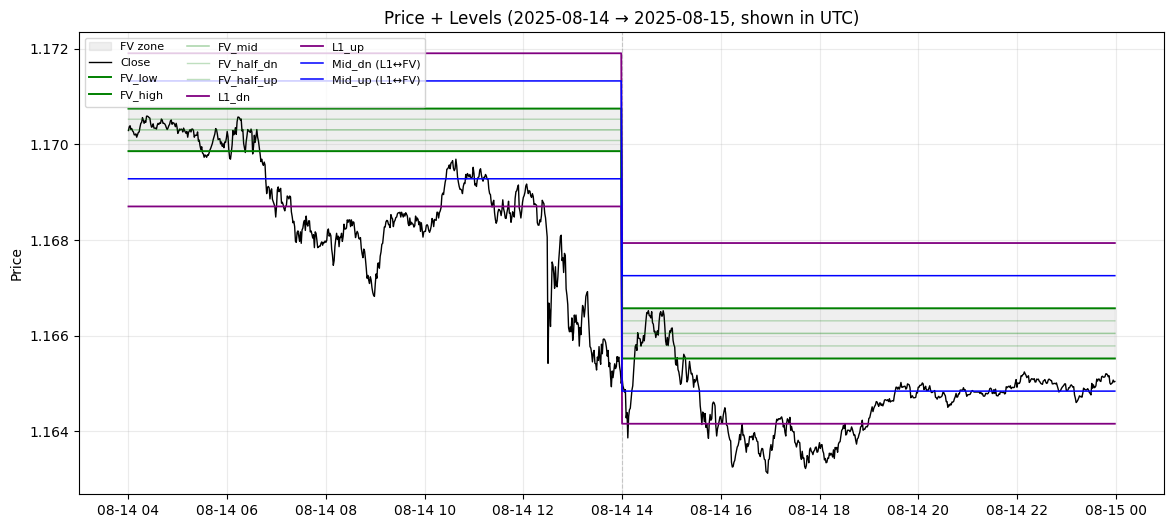

In [12]:
# 3 days starting Aug 21, 2021 (UTC x-axis)
plot_levels_styled(df, start_date="2025-08-14", ndays=2, tz="UTC")




### Backtesting

In [13]:
import pandas as pd
import numpy as np

# =========================
# FV/L1 Backtester (US-hours aware, NA-vols excluded) + same-bar TP/SL filter
# =========================
def backtest(
    df: pd.DataFrame,
    start: str | None = None,
    end: str | None = None,
    *,
    pip_size: float = 0.00010,   # EURUSD: 0.0001
    brk_buf_pips: float = 0.8,   # breakout buffer
    sl_buf_pips:  float = 0.6,   # stop buffer
    tp_buf_pips:  float = 0.2,   # tiny TP overshoot (0.0 to disable)
    lot_size: float = 100000.0,  # units per leg (1 std lot = 100k)
    us_hours_only: bool = True,  # ONLY enter between 09:30–16:00 NY
):
    x = _slice_dates(df, start, end).sort_values("dt_utc").reset_index(drop=True)

    # buffers in raw price units
    brk_buf = brk_buf_pips * pip_size
    sl_buf  = sl_buf_pips  * pip_size
    tp_buf  = tp_buf_pips  * pip_size

    # breakout flags (post-warmup only)
    after_warmup = x["dt_utc"] >= x["ny_warmup_end_utc"]
    inside_now   = (x["Close"] >= x["FV_low_adj_active"]) & (x["Close"] <= x["FV_high_adj_active"])
    inside_prev  = inside_now.shift(1).fillna(False)

    x["breakout_up"] = after_warmup & inside_prev & (x["Close"] > x["FV_high_adj_active"] + brk_buf)
    x["breakout_dn"] = after_warmup & inside_prev & (x["Close"] < x["FV_low_adj_active"]  - brk_buf)

    trades = []
    for day, g in x.groupby("date_us_open", sort=True):
        g = g.reset_index(drop=True)

        # ---- exclude volatile days and NA volatility info
        iv = g.loc[0, "is_volatile"] if "is_volatile" in g.columns else pd.NA
        vs = g.loc[0, "vol_score"]   if "vol_score"   in g.columns else pd.NA
        if pd.isna(iv) or pd.isna(vs) or (pd.notna(iv) and int(iv) == 1):
            continue
        day_vol_score = float(vs)

        # session bounds (UTC tz-aware)
        ny_open_utc  = g.loc[0, "ny_open_utc"]
        ny_close_utc = g.loc[0, "ny_close_utc"]

        long_done = False
        short_done = False

        for i in range(len(g) - 1):
            row = g.loc[i]
            nxt = g.loc[i + 1]  # enter on next bar open

            entry_time = nxt["dt_utc"]  # tz-aware

            # enforce US market hours if requested
            if us_hours_only and not (ny_open_utc <= entry_time <= ny_close_utc):
                continue

            # ----- LONG -----
            if row["breakout_up"] and not long_done:
                entry_px = float(nxt["Open"])
                tp1 = float(row["L1_up_active"])     - tp_buf
                tp2 = float(row["L1_mid_up_active"]) - tp_buf
                sl1 = float(row["FV_mid_adj_active"]) - sl_buf
                sl2 = float(row["FV_low_adj_active"]) - sl_buf

                t1 = _first_touch(g, i+1, "long",  entry_px, tp1, sl1, entry_time)
                t2 = _first_touch(g, i+1, "long",  entry_px, tp2, sl2, entry_time)

                if t1: trades.append({**t1, "leg":"TP1@L1_up",  "day":day, "units": lot_size, "vol_score": day_vol_score})
                if t2: trades.append({**t2, "leg":"TP2@L1_mid", "day":day, "units": lot_size, "vol_score": day_vol_score})
                long_done = True

            # ----- SHORT -----
            if row["breakout_dn"] and not short_done:
                entry_px = float(nxt["Open"])
                tp1 = float(row["L1_dn_active"])     + tp_buf
                tp2 = float(row["L1_mid_dn_active"]) + tp_buf
                sl1 = float(row["FV_mid_adj_active"]) + sl_buf
                sl2 = float(row["FV_high_adj_active"]) + sl_buf

                t1 = _first_touch(g, i+1, "short", entry_px, tp1, sl1, entry_time)
                t2 = _first_touch(g, i+1, "short", entry_px, tp2, sl2, entry_time)

                if t1: trades.append({**t1, "leg":"TP1@L1_dn",  "day":day, "units": lot_size, "vol_score": day_vol_score})
                if t2: trades.append({**t2, "leg":"TP2@L1_mid", "day":day, "units": lot_size, "vol_score": day_vol_score})
                short_done = True

    trades = pd.DataFrame(trades)

    # derived cols
    if not trades.empty:
        trades["pnl_pips"] = trades["pnl"] / pip_size
        trades["pnl_cash"] = trades["pnl"] * trades["units"]
        trades["holding_minutes"] = (
            (pd.to_datetime(trades["exit_time"]) - pd.to_datetime(trades["entry_time"]))
            .dt.total_seconds() / 60.0
        )

        # ----- NEW: drop same-bar TP/SL legs (keep EOD; keep the other leg if it's valid)
        same_bar_tp_sl = (trades["holding_minutes"] == 0) & (trades["outcome"].isin(["TP", "SL"]))
        trades = trades.loc[~same_bar_tp_sl].reset_index(drop=True)

    return trades, _summarize(trades, pip_size)

# ---- internals (unchanged) ----
def _slice_dates(df, start, end):
    x = df
    if start is not None:
        x = x[x["dt_utc"] >= pd.to_datetime(start, utc=True)]
    if end is not None:
        x = x[x["dt_utc"] <= pd.to_datetime(end, utc=True)]
    return x.copy()

def _first_touch(g, start_idx, side, entry_px, tp, sl, entry_time):
    """First-touch engine; SL wins if both touched; EOD flatten at last Close."""
    for j in range(start_idx, len(g)):
        bar = g.loc[j]
        lo, hi = float(bar["Low"]), float(bar["High"])
        t = bar["dt_utc"]

        if side == "long":
            hit_sl = lo <= sl
            hit_tp = hi >= tp
            if hit_sl and hit_tp:
                return {"side":side, "entry_time":entry_time, "entry_px":entry_px,
                        "exit_px":sl, "exit_time":t, "outcome":"SL", "pnl":sl-entry_px}
            if hit_sl:
                return {"side":side, "entry_time":entry_time, "entry_px":entry_px,
                        "exit_px":sl, "exit_time":t, "outcome":"SL", "pnl":sl-entry_px}
            if hit_tp:
                return {"side":side, "entry_time":entry_time, "entry_px":entry_px,
                        "exit_px":tp, "exit_time":t, "outcome":"TP", "pnl":tp-entry_px}
        else:  # short
            hit_sl = hi >= sl
            hit_tp = lo <= tp
            if hit_sl and hit_tp:
                return {"side":side, "entry_time":entry_time, "entry_px":entry_px,
                        "exit_px":sl, "exit_time":t, "outcome":"SL", "pnl":entry_px-sl}
            if hit_sl:
                return {"side":side, "entry_time":entry_time, "entry_px":entry_px,
                        "exit_px":sl, "exit_time":t, "outcome":"SL", "pnl":entry_px-sl}
            if hit_tp:
                return {"side":side, "entry_time":entry_time, "entry_px":entry_px,
                        "exit_px":tp, "exit_time":t, "outcome":"TP", "pnl":entry_px-tp}

    # EOD flatten
    last = g.loc[len(g)-1]
    px = float(last["Close"])
    pnl = (px - entry_px) if side == "long" else (entry_px - px)
    return {"side":side, "entry_time":entry_time, "entry_px":entry_px,
            "exit_px":px, "exit_time":last["dt_utc"], "outcome":"EOD", "pnl":pnl}

def _summarize(trades: pd.DataFrame, pip_size: float) -> dict:
    if trades is None or trades.empty:
        return {
            "n":0, "wins":0, "sls":0, "eods":0,
            "win_rate":0.0,
            "avg_pnl_raw":0.0, "cum_pnl_raw":0.0,
            "avg_pnl_pips":0.0, "cum_pnl_pips":0.0,
            "avg_pnl_cash":0.0, "cum_pnl_cash":0.0,
            "max_dd":0.0,
        }
    n = len(trades)
    wins = int((trades["outcome"] == "TP").sum())
    sls  = int((trades["outcome"] == "SL").sum())
    eods = int((trades["outcome"] == "EOD").sum())
    win_rate = wins / n if n else 0.0

    pnl_raw = trades["pnl"]
    pnl_pips = pnl_raw / pip_size
    pnl_cash = pnl_raw * trades["units"]

    avg_pnl_raw = float(pnl_raw.mean());   cum_pnl_raw = float(pnl_raw.sum())
    avg_pnl_pips = float(pnl_pips.mean()); cum_pnl_pips = float(pnl_pips.sum())
    avg_pnl_cash = float(pnl_cash.mean()); cum_pnl_cash = float(pnl_cash.sum())

    by_day = trades.groupby("day")["pnl"].sum()
    eq = by_day.cumsum()
    max_dd = float((eq.cummax() - eq).max()) if not eq.empty else 0.0

    return {
        "n": n, "wins": wins, "sls": sls, "eods": eods, "win_rate": win_rate,
        "avg_pnl_raw": avg_pnl_raw, "cum_pnl_raw": cum_pnl_raw,
        "avg_pnl_pips": avg_pnl_pips, "cum_pnl_pips": cum_pnl_pips,
        "avg_pnl_cash": avg_pnl_cash, "cum_pnl_cash": cum_pnl_cash,
        "max_dd": max_dd,
    }


In [16]:
import pandas as pd
import numpy as np

# ---- 1) pick 3–4 scenarios to compare (edit here only) ----
SCENARIOS = [
    # Core winners from your good year
    {"name":"S1_core_brk0.7_sl0.6_tp0.10", "pip_size":0.00010, "brk":0.7, "sl":0.6, "tp":0.10, "lot":300000.0},
    {"name":"S2_core_brk0.7_sl0.6_tp0.20", "pip_size":0.00010, "brk":0.7, "sl":0.6, "tp":0.20, "lot":300000.0},

    # Cautious for choppy regimes (stricter breakout or wider stop, no TP cushion)
    {"name":"S3_cautious_brk0.8_sl0.6_tp0.10", "pip_size":0.00010, "brk":0.8, "sl":0.6, "tp":0.10, "lot":300000.0},
    {"name":"S4_cautious_brk0.7_sl0.7_tp0.00", "pip_size":0.00010, "brk":0.7, "sl":0.7, "tp":0.00, "lot":300000.0},

    # Early/momentum-leaning variants
    {"name":"S5_early_brk0.6_sl0.6_tp0.10",   "pip_size":0.00010, "brk":0.6, "sl":0.6, "tp":0.10, "lot":300000.0},
    {"name":"S6_tightSL_brk0.7_sl0.5_tp0.10", "pip_size":0.00010, "brk":0.7, "sl":0.5, "tp":0.10, "lot":300000.0},
]


# ---- 2) metrics helpers (summary only) ----
def profit_factor(trades: pd.DataFrame) -> float:
    if trades is None or trades.empty: return 0.0
    wins  = trades.loc[trades["outcome"]=="TP","pnl_pips"].sum()
    losses = -trades.loc[trades["outcome"]=="SL","pnl_pips"].sum()
    return float(wins / losses) if losses > 0 else float("inf")

def max_dd_pips(trades: pd.DataFrame) -> float:
    if trades is None or trades.empty: return 0.0
    eq = trades.groupby("day")["pnl_pips"].sum().cumsum()
    return float((eq.cummax() - eq).max()) if not eq.empty else 0.0

def avg_win_loss(trades: pd.DataFrame) -> tuple[float,float]:
    if trades is None or trades.empty: return (0.0, 0.0)
    w = trades.loc[trades["outcome"]=="TP","pnl_pips"]
    l = trades.loc[trades["outcome"]=="SL","pnl_pips"]
    return float(w.mean()) if not w.empty else 0.0, float(l.mean()) if not l.empty else 0.0

# ---- 3) run scenarios and print summaries ----
def run_scenarios(df, start, end, scenarios=SCENARIOS, us_hours_only=True):
    rows = []
    for sc in scenarios:
        nm, ps, brk, sl, tp, lot = sc["name"], sc["pip_size"], sc["brk"], sc["sl"], sc["tp"], sc["lot"]
        trades, summ = backtest(
            df,
            start=start, end=end,
            pip_size=ps,
            brk_buf_pips=brk,
            sl_buf_pips=sl,
            tp_buf_pips=tp,
            lot_size=lot,
            us_hours_only=us_hours_only,
        )
        pf   = profit_factor(trades)
        mdd  = max_dd_pips(trades)
        aw, al = avg_win_loss(trades)
        rows.append({
            "scenario": nm,
            "pip_size": ps,
            "brk": brk, "sl": sl, "tp": tp,
            "n": summ["n"],
            "win_rate": round(summ["win_rate"], 4),
            "avg_pnl_pips": round(summ["avg_pnl_pips"], 4),
            "cum_pnl_pips": round(summ["cum_pnl_pips"], 2),
            "avg_win_pips": round(aw, 2),
            "avg_loss_pips": round(al, 2),
            "profit_factor": round(pf, 2),
            "max_dd_pips": round(mdd, 2),
            "cum_pnl_cash": round(summ["cum_pnl_cash"], 2),
        })
    summ_df = pd.DataFrame(rows).sort_values("cum_pnl_pips", ascending=False).reset_index(drop=True)
    return summ_df

# ---- 4) call it on your full window (prints only) ----
summary_df = run_scenarios(
    df,
    start="2021-08-16",
    end="2024-08-14",
    scenarios=SCENARIOS,
    us_hours_only=True,
)

print(summary_df.to_string(index=False))


C:\Users\user\AppData\Local\Temp\ipykernel_22852\3756155674.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inside_prev  = inside_now.shift(1).fillna(False)
C:\Users\user\AppData\Local\Temp\ipykernel_22852\3756155674.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inside_prev  = inside_now.shift(1).fillna(False)
C:\Users\user\AppData\Local\Temp\ipykernel_22852\3756155674.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instea

                       scenario  pip_size  brk  sl  tp    n  win_rate  avg_pnl_pips  cum_pnl_pips  avg_win_pips  avg_loss_pips  profit_factor  max_dd_pips  cum_pnl_cash
   S5_early_brk0.6_sl0.6_tp0.10    0.0001  0.6 0.6 0.1 1553    0.4746        0.5455        847.11         12.74         -13.09           1.09       635.22      25413.36
S4_cautious_brk0.7_sl0.7_tp0.00    0.0001  0.7 0.7 0.0 1524    0.4711        0.5266        802.59         12.88         -13.24           1.08       650.04      24077.78
 S6_tightSL_brk0.7_sl0.5_tp0.10    0.0001  0.7 0.5 0.1 1523    0.4695        0.5181        789.02         12.81         -13.00           1.08       638.96      23670.48
    S2_core_brk0.7_sl0.6_tp0.20    0.0001  0.7 0.6 0.2 1521    0.4740        0.5132        780.58         12.68         -13.14           1.08       650.82      23417.25
    S1_core_brk0.7_sl0.6_tp0.10    0.0001  0.7 0.6 0.1 1523    0.4708        0.5004        762.13         12.78         -13.14           1.08       643.90 

In [ ]:
import pandas as pd
import numpy as np

# ========= 0) Fixed best backtest params  =========
BEST = {
    "name": "S5_early_brk0.6_sl0.6_tp0.10",
    "pip_size": 0.00010,   # EURUSD pip
    "brk": 0.6,
    "sl": 0.6,
    "tp": 0.10,
    "lot": 300000.0,       # 3 lots
    "cost_pips": 0.2       # per-leg round-trip cost for net calc
}

# ========= 1) Date windows =========
full_start = str(pd.to_datetime(df["dt_utc"]).min().date())
full_end   = str(pd.to_datetime(df["dt_utc"]).max().date())
train_end  = "2024-08-14"
oos_start  = "2024-08-15"
oos_end    = full_end

# ========= 2) Helpers =========
def profit_factor(tr):
    if tr is None or tr.empty: return 0.0
    wins  = tr.loc[tr["outcome"]=="TP","pnl_pips"].sum()
    losses = -tr.loc[tr["outcome"]=="SL","pnl_pips"].sum()
    return float(wins / losses) if losses > 0 else float("inf")

def max_dd_pips(tr):
    if tr is None or tr.empty: return 0.0
    eq = tr.groupby("day")["pnl_pips"].sum().cumsum()
    return float((eq.cummax() - eq).max()) if not eq.empty else 0.0

def avg_win_loss(tr):
    if tr is None or tr.empty: return (0.0, 0.0)
    w = tr.loc[tr["outcome"]=="TP","pnl_pips"]
    l = tr.loc[tr["outcome"]=="SL","pnl_pips"]
    return (float(w.mean()) if not w.empty else 0.0,
            float(l.mean()) if not l.empty else 0.0)

def run_backtest(df, start, end, p=BEST):
    trades, summ = backtest(
        df, start=start, end=end,
        pip_size=p["pip_size"], brk_buf_pips=p["brk"],
        sl_buf_pips=p["sl"], tp_buf_pips=p["tp"],
        lot_size=p["lot"], us_hours_only=True
    )
    return trades, summ

def summarize(trades, summ, start, end, p=BEST):
    n = int(summ["n"]); gross = float(summ["cum_pnl_pips"])
    net = gross - p["cost_pips"]*n
    pf  = profit_factor(trades)
    mdd = max_dd_pips(trades)
    aw, al = avg_win_loss(trades)
    return pd.DataFrame([{
        "scenario": p["name"],
        "period_start": start, "period_end": end,
        "pip_size": p["pip_size"], "brk": p["brk"], "sl": p["sl"], "tp": p["tp"], "lot_size": p["lot"],
        "trades": n, "win_rate": float(summ["win_rate"]),
        "avg_pnl_pips": float(summ["avg_pnl_pips"]),
        "cum_pnl_pips_gross": gross, "cum_pnl_pips_net": net,
        "avg_win_pips": aw, "avg_loss_pips": al,
        "profit_factor": pf, "max_dd_pips": mdd,
        "cum_pnl_cash": float(summ["cum_pnl_cash"])
    }])

# ========= 3) Coverage & main backtest (FULL period) =========
print("Coverage:", df["dt_utc"].min(), "→", df["dt_utc"].max(),
      "| days:", df["date_us_open"].nunique())
print(f"Running BEST: {BEST['name']} | brk={BEST['brk']} sl={BEST['sl']} tp={BEST['tp']} | pip={BEST['pip_size']} | lot={BEST['lot']}")

trades_full, summary_full_raw = run_backtest(df, full_start, full_end, BEST)

# quick preview (no Excel write here—just display)
preview_cols = ["day","leg","side","entry_time","entry_px","exit_time","exit_px","outcome","pnl_pips","pnl_cash","holding_minutes"]
print("\nTrades preview (head):")
print(trades_full[preview_cols].head().to_string(index=False))

# ========= 4) Summaries (FULL + OOS) =========
summary_full = summarize(trades_full, summary_full_raw, full_start, full_end, BEST)

trades_oos, summary_oos_raw = run_backtest(df, oos_start, oos_end, BEST)
summary_oos  = summarize(trades_oos, summary_oos_raw, oos_start, oos_end, BEST)

# ========= 5) Excel outputs (two files, one sheet each) =========
summary_full.to_excel("best_model_full_summary.xlsx", index=False)
summary_oos.to_excel("best_model_oos_summary.xlsx", index=False)

print("\nSaved:")
print("  • best_model_full_summary.xlsx")
print("  • best_model_oos_summary.xlsx")

print("\nFull summary:\n", summary_full.to_string(index=False))
print("\nOOS summary:\n",  summary_oos.to_string(index=False))


Coverage: 2021-08-16 00:00:00+00:00 → 2025-08-14 23:59:00+00:00 | days: 1043
Running BEST: S5_early_brk0.6_sl0.6_tp0.10 | brk=0.6 sl=0.6 tp=0.1 | pip=0.0001 | lot=300000.0


C:\Users\user\AppData\Local\Temp\ipykernel_22852\3756155674.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inside_prev  = inside_now.shift(1).fillna(False)



Trades preview (head):
       day        leg  side                entry_time  entry_px                 exit_time  exit_px outcome  pnl_pips    pnl_cash  holding_minutes
2021-08-18  TP1@L1_dn short 2021-08-18 14:29:00+00:00   1.17085 2021-08-18 15:26:00+00:00 1.169595      TP 12.549502  376.485060             57.0
2021-08-18 TP2@L1_mid short 2021-08-18 14:29:00+00:00   1.17085 2021-08-18 15:25:00+00:00 1.170278      TP  5.724502  171.735060             56.0
2021-08-19  TP1@L1_up  long 2021-08-19 14:02:00+00:00   1.16994 2021-08-19 14:07:00+00:00 1.169418      SL -5.219845 -156.595344              5.0
2021-08-19 TP2@L1_mid  long 2021-08-19 14:02:00+00:00   1.16994 2021-08-19 14:09:00+00:00 1.169013      SL -9.269845 -278.095344              7.0
2021-08-19  TP1@L1_dn short 2021-08-19 14:21:00+00:00   1.16900 2021-08-19 14:25:00+00:00 1.169538      SL -5.380155 -161.404656              4.0


C:\Users\user\AppData\Local\Temp\ipykernel_22852\3756155674.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inside_prev  = inside_now.shift(1).fillna(False)



Saved:
  • best_model_full_summary.xlsx
  • best_model_oos_summary.xlsx

Full summary:
                     scenario period_start period_end  pip_size  brk  sl  tp  lot_size  trades  win_rate  avg_pnl_pips  cum_pnl_pips_gross  cum_pnl_pips_net  avg_win_pips  avg_loss_pips  profit_factor  max_dd_pips  cum_pnl_cash
S5_early_brk0.6_sl0.6_tp0.10   2021-08-16 2025-08-14    0.0001  0.6 0.6 0.1  300000.0    2061  0.478894      0.382088          787.484293        375.284293     12.212591     -12.975416       1.049688   685.097519    23624.5288

OOS summary:
                     scenario period_start period_end  pip_size  brk  sl  tp  lot_size  trades  win_rate  avg_pnl_pips  cum_pnl_pips_gross  cum_pnl_pips_net  avg_win_pips  avg_loss_pips  profit_factor  max_dd_pips  cum_pnl_cash
S5_early_brk0.6_sl0.6_tp0.10   2024-08-15 2025-08-14    0.0001  0.6 0.6 0.1  300000.0     504  0.496032     -0.083404          -42.035753       -142.835753     10.652916     -12.601643       0.951981    427.78161  -

## ML MODEL

In [42]:
ml = trades.copy()
ml["entry_time_gmt"] = pd.to_datetime(ml["entry_time"], utc=True).dt.tz_localize(None)
ml["entry_dow_gmt"]  = ml["entry_time_gmt"].dt.day_name()
ml["entry_hour_gmt"] = ml["entry_time_gmt"].dt.hour
ml = ml[ml["outcome"].isin(["TP","SL"])]  # drop EOD
ml["y"] = (ml["outcome"]=="TP").astype(int)

features = ["vol_score","side","leg","entry_dow_gmt","entry_hour_gmt"]
ml = ml.dropna(subset=features+["y","entry_time_gmt"])

cut = pd.to_datetime("2024-08-15")
train = ml[ml["entry_time_gmt"] <  cut]
test  = ml[ml["entry_time_gmt"] >= cut]


In [44]:
# --- Add GMT day-of-week (and hour) to trades, right before ML --- At this point i assumed that new features should be added 
# --- Therefore, weekday GMT and hour GMT are added to trades dataframe ---

trades = trades.copy()

# Make entry times timezone-naive GMT (Excel/ML friendly)
trades["entry_time_gmt"] = pd.to_datetime(trades["entry_time"], utc=True).dt.tz_localize(None)

# New features for ML / Tableau
trades["entry_dow_gmt"]  = trades["entry_time_gmt"].dt.day_name()  # e.g., 'Tuesday'
trades["entry_hour_gmt"] = trades["entry_time_gmt"].dt.hour        # 0..23

# Quick sanity check
print(trades[["entry_time_gmt","entry_dow_gmt","entry_hour_gmt"]].head(2))


       entry_time_gmt entry_dow_gmt  entry_hour_gmt
0 2021-08-18 14:29:00     Wednesday              14
1 2021-08-18 14:29:00     Wednesday              14


### Goal & setup

We keep the same trading rules. We train a simple Logistic model that scores each entry and we only take high-score trades. We split by time (train → test). We pick the cutoff on train to maximize net pips after costs, then evaluate on unseen test

### Config

In [45]:

# Cut date for unseen/OOS evaluation (3y train → last 1y test)
CUT_DATE  = pd.to_datetime("2024-08-14")
COST_PIPS = 0.2       # round-trip cost per leg
CALIBRATE = True      # isotonic calibration using a time-ordered validation slice

# Best ruleset is already used to generate trades earlier.

### Building leak-free ML table with fixed parameters which will later be adjusted for better ML performance

In [46]:
def make_ml_table(trades: pd.DataFrame) -> pd.DataFrame:
    t = trades.copy()
    et = pd.to_datetime(t["entry_time"], utc=True)
    t["entry_time_gmt"] = et.dt.tz_localize(None)
    t["entry_dow_gmt"]  = t["entry_time_gmt"].dt.day_name()
    t["entry_hour_gmt"] = t["entry_time_gmt"].dt.hour
    cols = ["entry_time_gmt","vol_score","side","leg","entry_dow_gmt","entry_hour_gmt","outcome","pnl_pips"]
    t = t[[c for c in cols if c in t.columns]].dropna(subset=["entry_time_gmt","vol_score","side","leg","outcome"])
    t = t[t["outcome"].isin(["TP","SL"])].copy()           # drop EOD for binary target to keep it simple
    t["y"] = (t["outcome"] == "TP").astype(int)
    return t.sort_values("entry_time_gmt").reset_index(drop=True)

ml = make_ml_table(trades)
ml.head()


,entry_time_gmt,vol_score,side,leg,entry_dow_gmt,entry_hour_gmt,outcome,pnl_pips,y
0,2021-08-18 14:29:00,0.700000,short,TP1@L1_dn,Wednesday,14,TP,12.549502,1
1,2021-08-18 14:29:00,0.700000,short,TP2@L1_mid,Wednesday,14,TP,5.724502,1
2,2021-08-20 14:11:00,0.742371,short,TP1@L1_dn,Friday,14,SL,-6.711010,0
3,2021-08-20 14:11:00,0.742371,short,TP2@L1_mid,Friday,14,SL,-11.611010,0
4,2021-08-23 14:49:00,1.300000,long,TP1@L1_up,Monday,14,SL,-9.827754,0


### Time split

In [48]:
train = ml[ml["entry_time_gmt"] <  CUT_DATE].copy()
test  = ml[ml["entry_time_gmt"] >= CUT_DATE].copy()

X_train = train.drop(columns=["outcome","y"])
y_train = train["y"].values
X_test  = test.drop(columns=["outcome","y"])
y_test  = test["y"].values

print(f"Train rows: {len(train)} | Test rows: {len(test)}")
print(f"Train window: {train['entry_time_gmt'].min()} → {train['entry_time_gmt'].max()}")
print(f" Test window: {test['entry_time_gmt'].min()} → {test['entry_time_gmt'].max()}")


Train rows: 1305 | Test rows: 444
Train window: 2021-08-18 14:29:00 → 2024-08-13 15:09:00
 Test window: 2024-08-14 14:30:00 → 2025-08-13 18:18:00


### Class balance & drift check

In [49]:
tp_rate_train = float(train["y"].mean()) if len(train) else 0.5
tp_rate_test  = float(test["y"].mean())  if len(test)  else 0.5
print(f"Train TP rate: {tp_rate_train:.2%} | Test TP rate: {tp_rate_test:.2%}")

# Decide weighting from TRAIN only (no leakage)
use_balanced = (tp_rate_train < 0.45) or (tp_rate_train > 0.55)
print("Use class_weight='balanced'? →", use_balanced)
cw = "balanced" if use_balanced else None


Train TP rate: 52.95% | Test TP rate: 52.93%
Use class_weight='balanced'? → False


### Preprocess + Logistic model

In [50]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

num_cols = ["vol_score","entry_hour_gmt"]
cat_cols = ["side","leg","entry_dow_gmt"]

pre = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="drop"
)

base_logit = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs",
                               class_weight=cw, random_state=42))
])

# Time-ordered validation slice: last ~15% of TRAIN for calibration
logit = base_logit
if CALIBRATE and len(train) >= 200:
    cut_val = train["entry_time_gmt"].quantile(0.85)
    idx_fit = np.where(train["entry_time_gmt"] <  cut_val)[0]
    idx_val = np.where(train["entry_time_gmt"] >= cut_val)[0]
    if (len(np.unique(y_train[idx_fit]))==2) and (len(np.unique(y_train[idx_val]))==2):
        # Fit with calibration using our explicit time split
        cal = CalibratedClassifierCV(base_logit, method="isotonic", cv=[(idx_fit, idx_val)])
        cal.fit(X_train, y_train)
        logit = cal
    else:
        # Fallback: no calibration if a slice has only one class
        logit = base_logit.fit(X_train, y_train)
else:
    logit = base_logit.fit(X_train, y_train)

# Quick sanity: AUC on TRAIN (not a deployment metric, just for monitoring)
proba_train = logit.predict_proba(X_train)[:,1]
print("Train AUC:", round(roc_auc_score(y_train, proba_train), 3))


Train AUC: 0.686


### Pick cutoff on TRAIN for maximizing net pips after costs

In [51]:
def best_threshold(train_df, probs, grid=np.arange(0.50, 0.85, 0.02), cost=COST_PIPS):
    best_t, best_net = 0.50, -1e12
    for t in grid:
        sel = train_df[probs >= t]
        net = (sel["pnl_pips"].sum() - cost*len(sel)) if not sel.empty else -1e12
        if net > best_net:
            best_t, best_net = t, net
    return best_t

thr = best_threshold(train.assign(prob=proba_train), proba_train)
print("Chosen threshold on TRAIN:", round(thr, 2))


Chosen threshold on TRAIN: 0.7


### Evaluate on unseen test vs rules-only

In [60]:
def kpis(df):
    if df.empty:
        return dict(n=0, gross_pips=0.0, net_pips=0.0, pf=0.0, dd=0.0)
    gross = float(df["pnl_pips"].sum())
    net   = gross - COST_PIPS*len(df)
    wins  = float(df.loc[df["outcome"]=="TP","pnl_pips"].sum())
    losses= -float(df.loc[df["outcome"]=="SL","pnl_pips"].sum())
    pf    = (wins/losses) if losses>0 else float("inf")
    eq    = df.groupby(df["entry_time_gmt"].dt.date)["pnl_pips"].sum().cumsum()
    dd    = float((eq.cummax()-eq).max()) if not eq.empty else 0.0
    return dict(n=len(df), gross_pips=round(gross,2), net_pips=round(net,2), pf=round(pf,2), dd=round(dd,2))

def win_rate(df):
    return float((df["outcome"] == "TP").mean()) if not df.empty else 0.0

proba_test = logit.predict_proba(X_test)[:,1]
test_sel   = test.assign(prob=proba_test).query("prob >= @thr")

baseline_oos = kpis(test)        # rules-only (all test trades)
logit_oos    = kpis(test_sel)    # filtered by threshold

wr_base = win_rate(test)
wr_filt = win_rate(test_sel)

print(f"Cut date: {CUT_DATE.date()} | Cost: {COST_PIPS} pips/leg | Calibrated: {CALIBRATE}")
print("Rules-only OOS :", baseline_oos, "| Win rate:", f"{wr_base:.1%}")
print("Logistic OOS   :", logit_oos,    "| Win rate:", f"{wr_filt:.1%}")
print(f"Δ trades: {baseline_oos['n']}→{logit_oos['n']}, "
      f"Δ net pips: {baseline_oos['net_pips']}→{logit_oos['net_pips']}, "
      f"Δ DD: {baseline_oos['dd']}→{logit_oos['dd']}")


Cut date: 2024-08-14 | Cost: 0.2 pips/leg | Calibrated: True
Rules-only OOS : {'n': 444, 'gross_pips': -174.46, 'net_pips': -263.26, 'pf': 0.93, 'dd': 509.92} | Win rate: 52.9%
Logistic OOS   : {'n': 155, 'gross_pips': 84.42, 'net_pips': 53.42, 'pf': 1.11, 'dd': 147.34} | Win rate: 69.7%
Δ trades: 444→155, Δ net pips: -263.26→53.42, Δ DD: 509.92→147.34


### Export for Tableau

In [26]:
preds_out = (test.assign(proba_tp_logit=proba_test)
                 [["entry_time_gmt","side","leg","vol_score","pnl_pips","outcome","proba_tp_logit"]]
                 .sort_values("entry_time_gmt"))
preds_out["suggest_trade"] = (preds_out["proba_tp_logit"] >= thr).astype(int)
preds_out.to_csv("ml_predictions_logit.csv", index=False)

filtered_trades = (test_sel[["entry_time_gmt","side","leg","vol_score","pnl_pips","outcome","prob"]]
                   .rename(columns={"prob":"proba_tp_logit"}))
filtered_trades.to_csv("ml_filtered_trades_logit.csv", index=False)

print(f"Saved: ml_predictions_logit.csv (rows={len(preds_out)})")
print(f"Saved: ml_filtered_trades_logit.csv (rows={len(filtered_trades)})")


Saved: ml_predictions_logit.csv (rows=444)
Saved: ml_filtered_trades_logit.csv (rows=155)


In [62]:
trades.count

<bound method DataFrame.count of        side                entry_time  entry_px   exit_px  \
0     short 2021-08-18 14:29:00+00:00   1.17085  1.169595   
1     short 2021-08-18 14:29:00+00:00   1.17085  1.170278   
2     short 2021-08-20 14:11:00+00:00   1.16736  1.168031   
3     short 2021-08-20 14:11:00+00:00   1.16736  1.168521   
4      long 2021-08-23 14:49:00+00:00   1.17407  1.173087   
...     ...                       ...       ...       ...   
1929   long 2025-08-12 15:05:00+00:00   1.16642  1.169552   
1930   long 2025-08-13 14:04:00+00:00   1.17093  1.171895   
1931   long 2025-08-13 14:04:00+00:00   1.17093  1.171317   
1932  short 2025-08-13 18:18:00+00:00   1.16964  1.170363   
1933  short 2025-08-13 18:18:00+00:00   1.16964  1.170808   

                     exit_time outcome       pnl         leg         day  \
0    2021-08-18 15:26:00+00:00      TP  0.001255   TP1@L1_dn  2021-08-18   
1    2021-08-18 15:25:00+00:00      TP  0.000572  TP2@L1_mid  2021-08-18   
2    2

In [64]:
import pandas as pd
import numpy as np

# ---- assumes you already have these from your ML run ----
# trades        -> from backtest with S5 brk=0.6 sl=0.6 tp=0.10
# CUT_DATE      -> pd.Timestamp("2024-08-15")
# COST_PIPS     -> 0.2
# CALIBRATE     -> True/False
# logit         -> fitted Pipeline/Calibrated model
# thr           -> chosen on TRAIN to maximize net pips
# (and train/test DataFrames already built the same way you trained)

# 1) Recreate the ML table in the same way (to guarantee columns)
def make_ml_table(trades: pd.DataFrame) -> pd.DataFrame:
    t = trades.copy()
    et = pd.to_datetime(t["entry_time"], utc=True)  # tz-aware UTC
    t["entry_time_gmt"] = et.dt.tz_localize(None)   # naive GMT for Excel friendliness
    # Also create New York local time (naive) for viz
    t["entry_time_ny"]  = et.dt.tz_convert("America/New_York").dt.tz_localize(None)
    t["entry_dow_gmt"]  = t["entry_time_gmt"].dt.day_name()
    t["entry_hour_gmt"] = t["entry_time_gmt"].dt.hour
    # label for ML
    t = t[t["outcome"].isin(["TP","SL"])].copy()
    t["y"] = (t["outcome"]=="TP").astype(int)
    # a simple vol bucket for Tableau
    try:
        t["vol_bucket"] = pd.qcut(t["vol_score"], q=3, labels=["low","med","high"], duplicates="drop")
    except Exception:
        t["vol_bucket"] = pd.cut(t["vol_score"], bins=3, labels=["low","med","high"])
    return t.reset_index(drop=True)

ml_all = make_ml_table(trades)

# 2) Mark split
ml_all["dataset_split"] = np.where(ml_all["entry_time_gmt"] < CUT_DATE, "train", "test")

# 3) Build X the same way as training
features = ["vol_score","side","leg","entry_dow_gmt","entry_hour_gmt"]
X_all = ml_all[features].copy()

# 4) Get probabilities for ALL rows using the fitted model
proba_all = logit.predict_proba(X_all)[:,1]
ml_all["proba_tp_logit"] = proba_all

# 5) Suggest trade (we’ll compute it for both splits; you’ll evaluate OOS on test)
ml_all["suggest_trade"] = (ml_all["proba_tp_logit"] >= thr).astype(int)

# 6) Basic per-row fields you’ll likely chart in Tableau
keep_cols = [
    "dataset_split","entry_time_gmt","entry_time_ny","day","side","leg",
    "vol_score","vol_bucket","entry_dow_gmt","entry_hour_gmt",
    "outcome","y","pnl_pips","pnl_cash","proba_tp_logit","suggest_trade"
]
events_export = ml_all[keep_cols].sort_values("entry_time_gmt").reset_index(drop=True)

# 7) Quick OOS KPIs (to park in a sheet)
def kpis(df):
    if df.empty:
        return dict(n=0, gross_pips=0.0, net_pips=0.0, pf=0.0, dd=0.0, wr=0.0)
    gross = float(df["pnl_pips"].sum())
    net   = gross - COST_PIPS*len(df)
    wins  = float(df.loc[df["outcome"]=="TP","pnl_pips"].sum())
    losses= -float(df.loc[df["outcome"]=="SL","pnl_pips"].sum())
    pf    = (wins/losses) if losses>0 else float("inf")
    eq    = df.groupby(pd.to_datetime(df["entry_time_gmt"]).dt.date)["pnl_pips"].sum().cumsum()
    dd    = float((eq.cummax()-eq).max()) if not eq.empty else 0.0
    wr    = float((df["outcome"]=="TP").mean())
    return dict(n=len(df), gross_pips=round(gross,2), net_pips=round(net,2),
                pf=round(pf,2), dd=round(dd,2), wr=round(wr*100,1))

oos_rules   = kpis(events_export.query("dataset_split=='test'"))
oos_filtered= kpis(events_export.query("dataset_split=='test' and suggest_trade==1"))

kpis_df = pd.DataFrame([
    {"model":"Rules-only (test)", **oos_rules},
    {"model":"Logistic-filtered (test)", **oos_filtered},
])

# 8) Meta sheet (params, cut, threshold, calibration flag, class balance)
tp_rate_train = float((events_export.query("dataset_split=='train'")["outcome"]=="TP").mean())
tp_rate_test  = float((events_export.query("dataset_split=='test'")["outcome"]=="TP").mean())
meta = pd.DataFrame([{
    "ruleset": "S5_early_brk0.6_sl0.6_tp0.10",
    "pip_size": 0.00010, "brk": 0.6, "sl": 0.6, "tp": 0.10, "lot_size": 300000.0,
    "cut_date": CUT_DATE.date(), "cost_pips": COST_PIPS,
    "calibrated": bool(CALIBRATE), "threshold": float(thr),
    "train_tp_rate_%": round(tp_rate_train*100,2),
    "test_tp_rate_%": round(tp_rate_test*100,2),
}])

# 9) Export everything to one Excel (events + KPIs + meta)
with pd.ExcelWriter("ml_events_package.xlsx", engine="xlsxwriter") as xw:
    events_export.to_excel(xw, sheet_name="events_all", index=False)
    kpis_df.to_excel(xw, sheet_name="oos_kpis", index=False)
    meta.to_excel(xw, sheet_name="meta", index=False)

print("Saved → ml_events_package.xlsx")
print("Sheets: events_all (rows: {}), oos_kpis, meta".format(len(events_export)))


Saved → ml_events_package.xlsx
Sheets: events_all (rows: 1749), oos_kpis, meta
